# Inference in a discretized 1d SSM

This script implements algorithms and examples for inference in a state space model with a real-valued scalar hidden state and a real-valued scalar observation. The basic method is based on discretization and the HMM smoother; a novel method is also derived based on KDE for the case where the likelihood cannot be evaluated pointwise. For details see  this paper.


"Computation and visualization of posterior densities
in scalar nonlinear and non-Gaussian Bayesian filtering and smoothing problems",
Michael Roth and Fredrik Gustafsson
Reference:
https://liu.diva-portal.org/smash/get/diva2:1173608/FULLTEXT02.pdf
Part of: 2017 IEEE INTERNATIONAL CONFERENCE ON ACOUSTICS, SPEECH AND SIGNAL PROCESSING (ICASSP),
2017, pp. 4686-4690. ISBN: 978-1-5090- 4117-6
Book Series: International Conference on Acoustics Speech and Signal Processing ICASSP, 1520-6149.

Original matlab code: http://users.isy.liu.se/en/rt/roth/rothICASSP2017.zip

Converted to JAX by benlau6
https://github.com/probml/pyprobml/pull/700





# Setup

In [1]:
from typing import Callable
import functools

import jax
from jax import lax
from jax import numpy as jnp
from jax import scipy as jsp
from jax import random
import matplotlib.pyplot as plt


plt.rcParams.update({"font.size": 16})

In [2]:
try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml

In [3]:
pml.latexify(width_scale_factor=1, fig_height=1.5)

/opt/anaconda3/lib/python3.8/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


# Data generator

We assume the model is
$$x_{k+1} = x_k + v_k$$
$$y_{k} = x_k + e_k$$
where $v_k$ is the system noise and $e_k$ is the observation noise.

In [4]:
def generate_x_true(rng_key: jnp.DeviceArray, max_iter: int, x0_rvs: Callable, v_rvs: Callable, f: Callable):
    def get_next_x_true(x_prev, k, v):
        x_true = f(x_prev, v[k - 1], k=k - 1)
        return x_true, x_true

    rng_keys = random.split(rng_key, num=2)
    x0 = x0_rvs(rng_keys[0], shape=())
    v = v_rvs(rng_keys[1], shape=(max_iter + 1,))

    get_next_x_true_func = functools.partial(get_next_x_true, v=v)
    _, x_true = lax.scan(get_next_x_true_func, init=x0, xs=jnp.arange(1, max_iter + 1))
    return jnp.array([x0, *x_true])


def generate_y(rng_key: jnp.DeviceArray, x_true: jnp.DeviceArray, e_rvs: Callable, h: Callable):
    shape = x_true.shape
    e = e_rvs(rng_key, shape=shape)
    y = h(x_true, e)
    # y = y.at[0].set(jnp.inf)
    return y

In [14]:
def experiment_setup(
    rng_key, grid_minval, grid_maxval, num_grid_points, x0_rvs, v_rvs, e_rvs, f, h, max_iter, plot_xy=False
):
    # create 1d grid
    x_grid = jnp.linspace(grid_minval, grid_maxval, num_grid_points)

    # generate true states
    rng_key, rng_subkey = random.split(rng_key)
    x_true = generate_x_true(
        rng_subkey,
        max_iter=max_iter,
        x0_rvs=x0_rvs,
        v_rvs=v_rvs,
        f=f,
    )

    # generate measurement
    rng_key, rng_subkey = random.split(rng_key)
    y = generate_y(rng_subkey, x_true, e_rvs=e_rvs, h=h)

    if plot_xy:
        # plot trajectory and the measurement
        fig, ax = plt.subplots(figsize=(12, 8))
        # ax.set_title("Trajectory and Measurement versus time")
        ax.plot(range(max_iter + 1), x_true, "*-", label="True state", color="k", lw=4, markersize=12)
        ax.plot(range(max_iter + 1), y, "o-", label="Measurements", color="r", lw=4, markersize=12)
        # ax.set_ylabel("$x_k, y_k$")
        # ax.set_xlabel("k")
        ax.legend()
        ax.legend(prop={"size": 16})

    return x_grid, x_true, y

# Inference

In [6]:
def x_pdf(x_new, x, k, v_pdf, f):
    v = f(x=x, v=0, k=k)
    return v_pdf(x_new - v)


def y_likelihood(y, x, e_pdf, h):
    e = h(x=x, e=0)
    return e_pdf(y - e)


def point_mass_density(
    y: jnp.DeviceArray,
    x_grid: jnp.DeviceArray,
    x0_pdf: Callable,
    x_pdf: Callable,
    v_pdf: Callable,
    e_pdf: Callable,
    f: Callable,
    h: Callable,
):
    num_grid_points = x_grid.shape[0]
    max_iter = len(y) - 1
    delta = x_grid[1] - x_grid[0]
    X = jnp.tile(x_grid, (num_grid_points, 1))

    p_filter0 = x0_pdf(x_grid)
    p_filter0 /= jnp.sum(p_filter0)
    p_pred0 = [jnp.inf] * num_grid_points

    def get_next_filter_pred_densities(p_filter_prev, k, x_grid, X, y):
        # p(xk, xk-1 | y(1:k-1))
        px = x_pdf(k=k - 1, x_new=X.T, x=X, v_pdf=v_pdf, f=f)
        p_joint = px * p_filter_prev

        # p(xk | y(1:k-1))
        p_pred_k = jnp.sum(p_joint, axis=1)
        p_pred_k /= jnp.sum(p_pred_k)

        # p(xk | y(1:k))
        p_filter_k = p_pred_k * y_likelihood(y[k], x_grid, e_pdf, h)
        p_filter_k /= jnp.sum(p_filter_k)
        return p_filter_k, [p_filter_k, p_pred_k]

    get_next_filter_pred_densities_func = functools.partial(get_next_filter_pred_densities, x_grid=x_grid, X=X, y=y)

    _, (p_filter, p_pred) = lax.scan(
        get_next_filter_pred_densities_func,
        init=p_filter0,
        xs=jnp.arange(1, max_iter + 1),
    )
    p_filter = jnp.array([p_filter0, *p_filter])
    p_pred = jnp.array([p_pred0, *p_pred])

    p_smooth_max_iter = jnp.array(p_filter[max_iter].copy())

    def get_next_smooth_density(p_smooth_prev, k, X, p_filter, p_pred):
        # p(xk, xk-1 | y(1:k-1))
        px = x_pdf(k=k, x_new=X, x=X.T, v_pdf=v_pdf, f=f)
        px = px * p_smooth_prev / p_pred[k + 1, :]
        px = jnp.nan_to_num(px)

        p_smooth_k = jnp.sum(px, axis=1)  # marginalize
        p_smooth_k *= p_filter[k, :]  # multiply p(xk|yk)
        p_smooth_k /= jnp.sum(p_smooth_k)
        return p_smooth_k, p_smooth_k

    get_next_smooth_density_func = functools.partial(
        get_next_smooth_density,
        X=X,
        p_filter=p_filter,
        p_pred=p_pred,
    )
    _, p_smooth = lax.scan(
        get_next_smooth_density_func, init=p_smooth_max_iter, xs=jnp.arange(0, max_iter), reverse=True
    )
    p_smooth = jnp.array([*p_smooth, p_smooth_max_iter])

    return p_filter / delta, p_pred / delta, p_smooth / delta

# Plotting

In [7]:
def plot_density(
    x_true,
    y,
    inv_h,
    x_grid,
    p_pred,
    p_filter,
    p_smooth=None,
    k=1,
    legend=True,
    ax=None,
    vfill=None,
    title="",
    linewidth=4.5,
):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))

    # ax.plot(x_grid, p_pred[k], label="Prediction", linewidth=linewidth)
    ax.plot(x_grid, p_filter[k], label="Filtering", color="blue", linewidth=linewidth)
    if p_smooth is not None:
        ax.plot(x_grid, p_smooth[k], label="Smoothing", color="orange", linewidth=linewidth)

    y_max = max(p_pred[k].max(), p_filter[k].max()) * 1.05
    if p_smooth is not None:
        y_max = max(y_max, p_smooth[k].max()) * 1.05
    ax.vlines([x_true[k]], ymin=0, ymax=y_max, label="True state", color="k")
    ax.vlines(
        inv_h(y[k]),
        ymin=0,
        ymax=y_max,
        color="r",
        label="Measurement",
    )
    if vfill is not None:
        ax.axvspan(*vfill, color="lightgrey", alpha=0.4, label="Measurement range")
    ax.set_ylim(0)
    ax.set_ylabel(f"$p(x_{{{k}}}|y_{{1:{k}}})$")
    ax.set_xlabel("x")
    if legend:
        ax.legend(prop={"size": 16})
    if title:
        ax.set_title(title)
        ax.title.set_fontsize(16)
        # ax.set_fontsize(16)


def mean_point_mass(xs, ps):
    delta = xs[1] - xs[0]
    return jnp.sum(xs * ps * delta, axis=1)


def variance_point_mass(xs, ps):
    delta = xs[1] - xs[0]
    return jnp.sum((xs**2) * ps * delta, axis=1) - mean_point_mass(xs, ps) ** 2


def plot_line(x_true, y, mean_x_filter, variance_x_filter, max_iter, mean_x_smooth=None, variance_x_smooth=None):
    # To plot x, y, and variance
    plt.figure(figsize=(12, 8))
    plt.plot(x_true, label="true", color="k")
    plt.plot(y, label="observed", color="r")

    plt.errorbar(
        range(max_iter + 1),
        mean_x_filter,
        yerr=jnp.sqrt(variance_x_filter),
        label="filtered mean",
    )

    if (mean_x_smooth is not None) and (variance_x_smooth is not None):
        plt.errorbar(
            range(max_iter + 1),
            mean_x_smooth,
            yerr=jnp.sqrt(variance_x_smooth),
            label="smoothed mean",
        )
    plt.legend()
    plt.title("States versus time")
    plt.xlabel("time")
    plt.ylabel("value")
    plt.xticks(range(max_iter + 1))


def val2grid(x, grid_minval, grid_maxval, num_grid_points):
    return (x - grid_minval) / (grid_maxval - grid_minval) * num_grid_points

In [29]:
def plot_densities(x_true, y, inv_h, x_grid, p_pred, p_filter, p_smooth, max_iter, legend=True, nrow=None, ncol=None):
    if (nrow is None) or (ncol is None):
        raise ValueError("Please provide nrow and ncol arguments")

    fig, axes = plt.subplots(nrow, ncol, figsize=(20, 10), sharex=True, sharey=True, constrained_layout=True)
    axes = axes.ravel()

    # plt.suptitle("All density plots to look for weird pattern")

    for k in range(1, nrow * ncol):
        plot_density(
            x_true,
            y,
            inv_h,
            x_grid=x_grid,
            p_pred=p_pred,
            p_filter=p_filter,
            p_smooth=p_smooth,
            k=k,
            ax=axes[k],
            legend=False,
            linewidth=1.5,
        )

    # set off k=0 empty plot and attach legend
    axes[0].axis("off")
    handles, labels = axes[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper left")

# Linear Gaussian dynamics, Student-t observations 

This is from Section 5.2 of the Roth paper.

In [35]:
# functions for student t random walk example

# state transition function
def state_trans_func(x, v, k=None):
    return x + v


# measurement function
def measure_func(x, e):
    return x + e


# to get x from measurement without noise
def inv_measure_func(y):
    return y


df_dynamics = 2  # large dof approximates Gaussian noise
df_obs = 2

# functions to get sample
def v_rvs(rng_key, shape):
    return random.t(rng_key, df=df_dynamics, shape=shape)


def e_rvs(rng_key, shape):
    return random.t(rng_key, df=df_obs, shape=shape)


def x0_rvs(rng_key, shape):
    return random.t(rng_key, df=df_dynamics, shape=shape)


# functions to get density
v_pdf = functools.partial(jsp.stats.t.pdf, df=df_dynamics)
e_pdf = functools.partial(jsp.stats.t.pdf, df=df_obs)  #
x0_pdf = functools.partial(jsp.stats.t.pdf, df=df_dynamics)


def student_t_random_walk_example(
    rng_key=random.PRNGKey(0), grid_minval=-60, grid_maxval=30, num_grid_points=500, max_iter=25
):
    # generate data points and densities
    x_grid, x_true, y = experiment_setup(
        rng_key=rng_key,
        grid_minval=grid_minval,
        grid_maxval=grid_maxval,
        num_grid_points=num_grid_points,
        x0_rvs=x0_rvs,
        v_rvs=v_rvs,
        e_rvs=e_rvs,
        f=state_trans_func,
        h=measure_func,
        max_iter=max_iter,
        plot_xy=True,
    )

    p_filter, p_pred, p_smooth = point_mass_density(
        y,
        x_grid,
        x0_pdf,
        x_pdf=x_pdf,
        v_pdf=v_pdf,
        e_pdf=e_pdf,
        f=state_trans_func,
        h=measure_func,
    )

    return x_grid, x_true, y, p_filter, p_pred, p_smooth

/opt/anaconda3/lib/python3.8/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


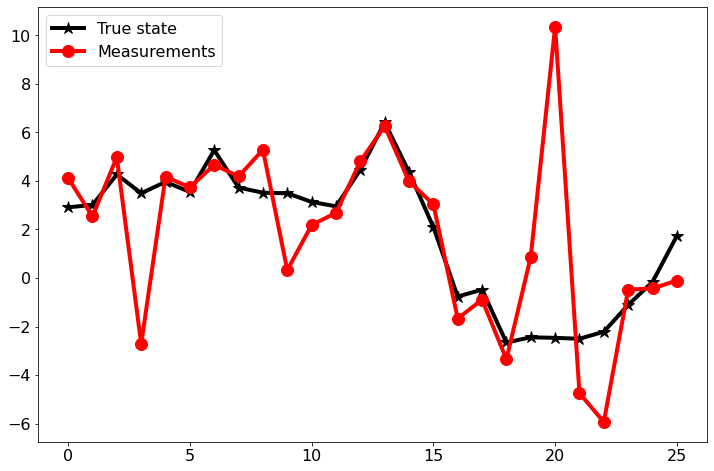

In [36]:
rng_key = random.PRNGKey(1)
grid_minval = -20
grid_maxval = 20
num_grid_points = 500
max_iter = 25

x_grid, x_true, y, p_filter, p_pred, p_smooth = student_t_random_walk_example(
    rng_key=rng_key,
    grid_minval=grid_minval,
    grid_maxval=grid_maxval,
    num_grid_points=num_grid_points,
    max_iter=max_iter,
)

pml.savefig("ssm_discretized_data")

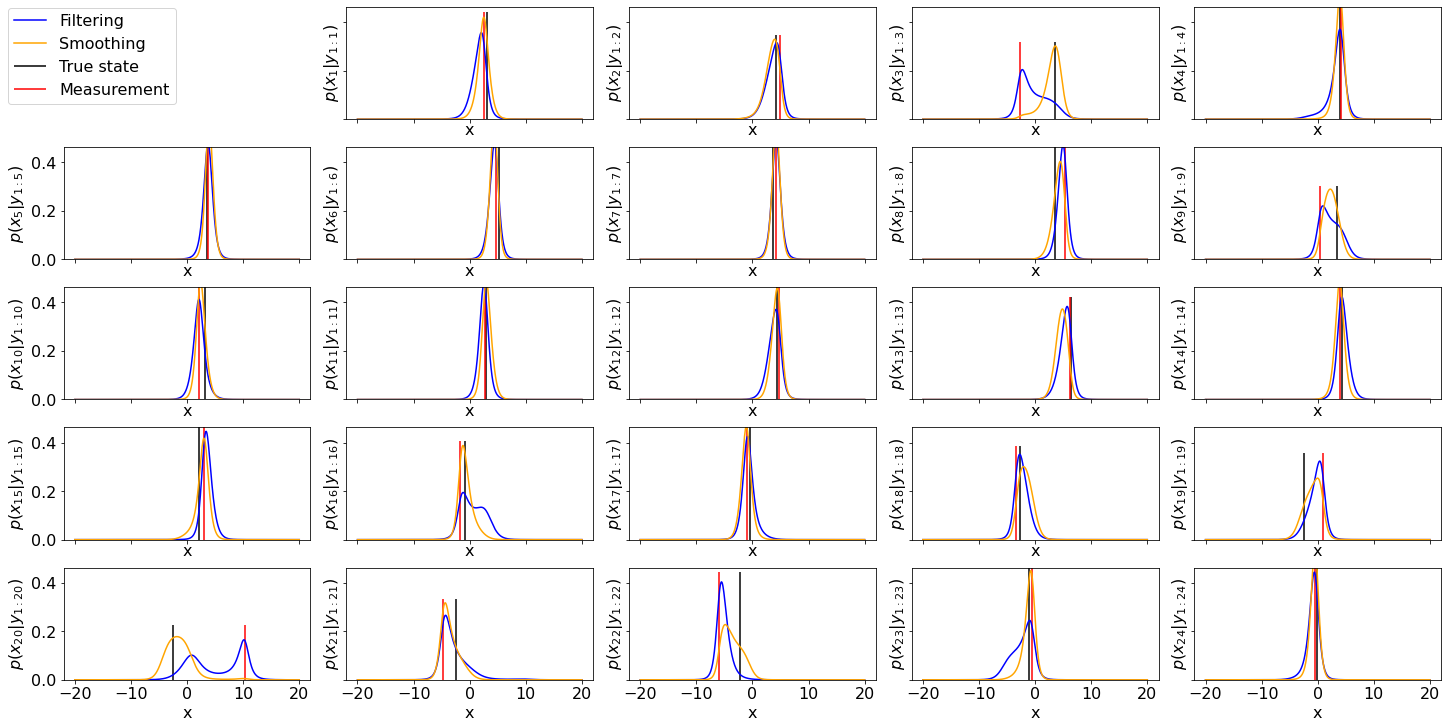

In [37]:
# look for a multimodal distribution by plotting all time steps
plot_densities(
    x_true,
    y,
    inv_measure_func,
    x_grid,
    p_pred,
    p_filter,
    p_smooth,
    max_iter,
    nrow=5,
    ncol=5,
)

ssm_discretized_t20


/opt/anaconda3/lib/python3.8/site-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


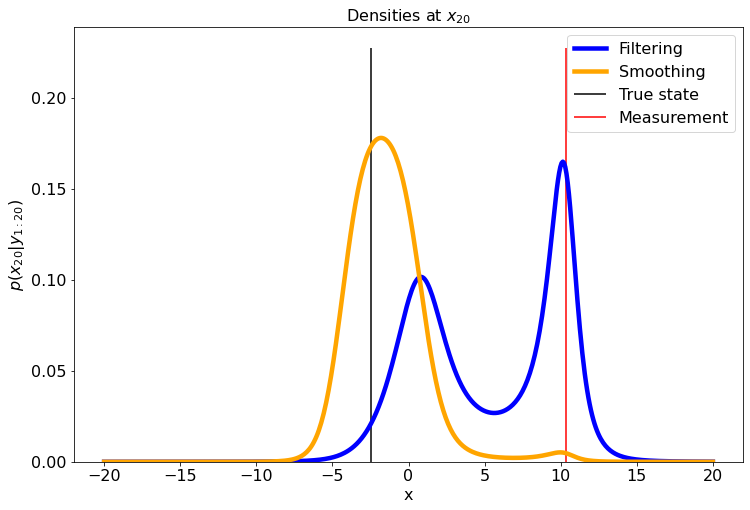

In [38]:
iter_ = 20
plot_density(
    x_true,
    y,
    inv_measure_func,
    x_grid,
    p_pred,
    p_filter,
    p_smooth,
    k=iter_,
    legend=True,
    ax=None,
    title=f"Densities at $x_{{{iter_}}}$",
)

fname = f"ssm_discretized_t{iter_}"
print(fname)
pml.savefig(fname)

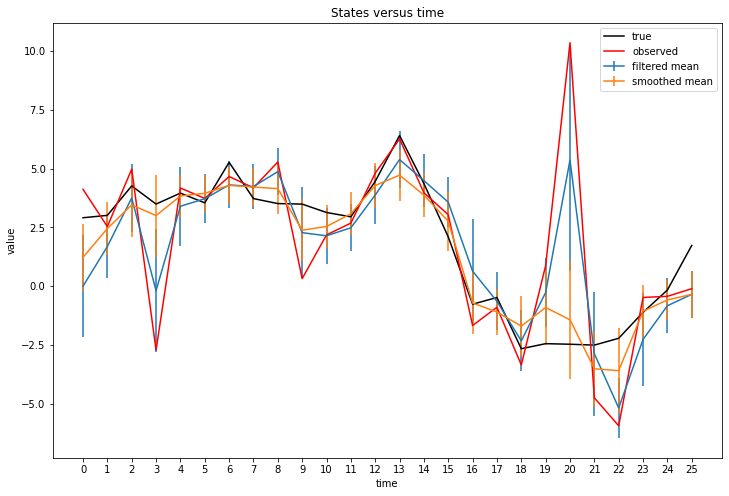

In [23]:
# filtered mean E[x(k) | y(1:k)]
mean_x_filter = mean_point_mass(x_grid, p_filter)
# variance +- sqrt{Var[x(k)|y(1:k)}
variance_x_filter = variance_point_mass(x_grid, p_filter)

# smoothed mean E[x(k) | y(1:T)]
mean_x_smooth = mean_point_mass(x_grid, p_smooth)
# variance +- sqrt{Var[x(k)|y(1:T)}, as a line plot
variance_x_smooth = variance_point_mass(x_grid, p_smooth)

# To plot x, y, and variance
plot_line(
    x_true,
    y,
    mean_x_filter,
    variance_x_filter,
    max_iter,
    mean_x_smooth=mean_x_smooth,
    variance_x_smooth=variance_x_smooth,
)
pml.savefig("ssm_discretized_lines")

# Heatmap

In [26]:
def plot_heatmap(density, x_true, y_obs, grid_minval, grid_maxval, num_grid_points, max_iter, title=""):
    # Plot heatmat to capture multi-modality
    fig, ax = plt.subplots(figsize=(12, 8))

    heatmap = ax.imshow(density.T, aspect="auto", interpolation="none")
    ax.title.set_text(title)
    ax.title.set_fontsize(16)

    xticks = range(max_iter + 1)
    yticks = jnp.arange(0, num_grid_points, num_grid_points / 6)
    ytick_labels = x_grid[yticks.astype(int)].round().astype(int)
    plt.xticks(xticks)
    plt.yticks(yticks, labels=ytick_labels)

    ax.set_xticks(jnp.arange(-0.5, max_iter + 1, 1), minor=True)
    ax.grid(which="minor", color="w", linewidth=2)
    plt.colorbar(heatmap, ax=ax, fraction=0.04, pad=0.04)

    x_true_ticks = val2grid(x_true, grid_minval, grid_maxval, num_grid_points)
    for x, y in zip(xticks, x_true_ticks.round().astype(int)):
        ax.text(x, y, "X", ha="center", va="center", color="red", fontsize=18)

    y_obs_ticks = val2grid(y_obs, grid_minval, grid_maxval, num_grid_points)
    for x, y in zip(xticks, y_obs_ticks.round().astype(int)):
        ax.text(x, y, "o", ha="center", va="center", color="red", fontsize=18)

    return fig

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


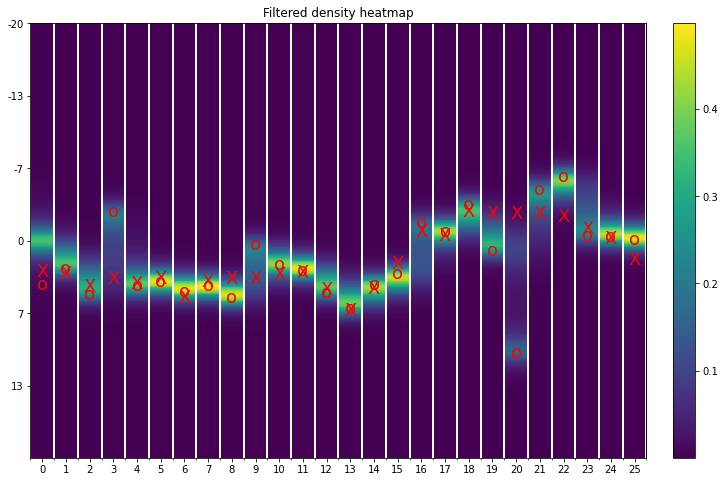

In [27]:
# Plot heatmap to capture multi-modality
plot_heatmap(p_filter, x_true, y, grid_minval, grid_maxval, num_grid_points, max_iter, title="Filtered density heatmap")

pml.savefig("ssm_discretized_filtering_heatmap")

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


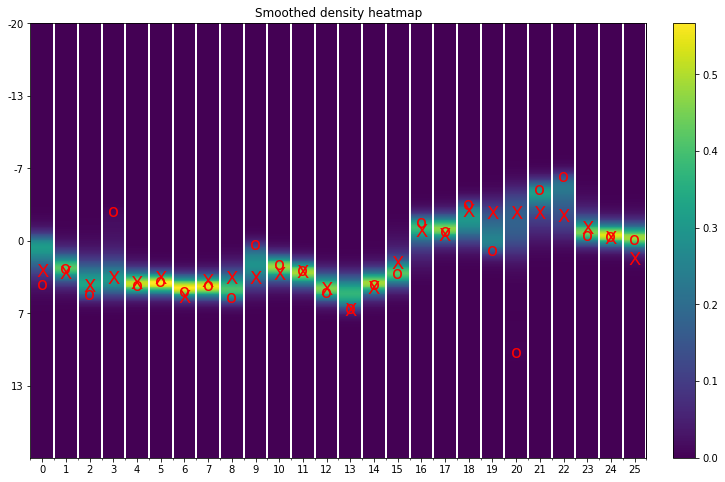

In [28]:
plot_heatmap(p_smooth, x_true, y, grid_minval, grid_maxval, num_grid_points, max_iter, title="Smoothed density heatmap")


pml.savefig("ssm_discretized_smoothing_heatmap")